# Fall 2023 NSDC at UCLA Project
## Group members: Sam Rhee (Project lead), Edward Fei, Zhiyi Chen, Elisabet Norgard, Olivia Nguyen

Our team worked on **Natural Language Processing** by analyzing movie reviews. We all learned something from our analysis, whether it's data visualization, Spacy package for NLP, sentiment analysis, or pandas.

In [739]:
# While these modules have been imported before, we include these for the sake of completion

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings

warnings.filterwarnings("ignore")

In [740]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [741]:
import chardet

with open("IMDb movies.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

df = pd.read_csv("IMDb movies.csv", encoding=result['encoding'])
df = df[['genre','description']]
df.head()

,genre,description
0,Romance,The adventures of a female reporter in the 1890s.
1,"Biography, Crime, Drama",True story of notorious Australian outlaw Ned ...
2,Drama,Two men of high rank are both wooing the beaut...
3,"Drama, History",The fabled queen of Egypt's affair with Roman ...
4,"Adventure, Drama, Fantasy",Loosely adapted from Dante's Divine Comedy and...


In [742]:
# filter null values
df.isna().any()

genre          False
description     True
dtype: bool

In [743]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace = True)

In [744]:
# Convert multi-label splitted by comma into lists
for i in range(len(df["genre"])):
    df["genre"][i] = df["genre"][i].replace(" ", "")
    df["genre"][i] = list(df["genre"][i].split(","))

In [745]:
# Simplify multi-label into multi-class problem
df['nGenre'] = [0 for i in range(len(df))]
for i in range(len(df)):
    df['nGenre'][i] = len(df['genre'][i])

df = df[df['nGenre']==1]

In [746]:
df = df[['genre','description']]
df['genre'] = [''.join(i) for i in df['genre']]
df.reset_index(drop = True, inplace = True)

In [747]:
# Explore genres with abundant data
df['genre'].value_counts()[0:7]

genre
Drama       12105
Comedy       7146
Horror       2241
Thriller     1217
Action        699
Western       588
Romance       415
Name: count, dtype: int64

In [748]:
def genre_encodings(genre):
    genre_list = ['Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Romance']
    return genre_list.index(genre)

In [749]:
for genre in df['genre'].value_counts()[0:7].index:
    # Extract the first three letters of the genre in lower case
    short_name = genre[:3].lower()
    # Create a DataFrame using the abbreviated genre name
    variable_name = 'df_' + short_name
    # Create a global variable with the constructed name
    globals()[variable_name] = df[df['genre'] == genre].reset_index(drop=True)[:400]

In [750]:
df_dra.head()

,genre,description
0,Drama,Two men of high rank are both wooing the beaut...
1,Drama,Richard of Gloucester uses manipulation and mu...
2,Drama,After Dr. Friedrich's wife becomes mentally un...
3,Drama,Single mother is separated from her children d...
4,Drama,"Leslie Swayne, an adventurer, in order to obta..."


In [751]:
# Concatenate all descriptions in drama genre for word cloud visualization
drama_corpus = ' '.join(df_dra['description'])

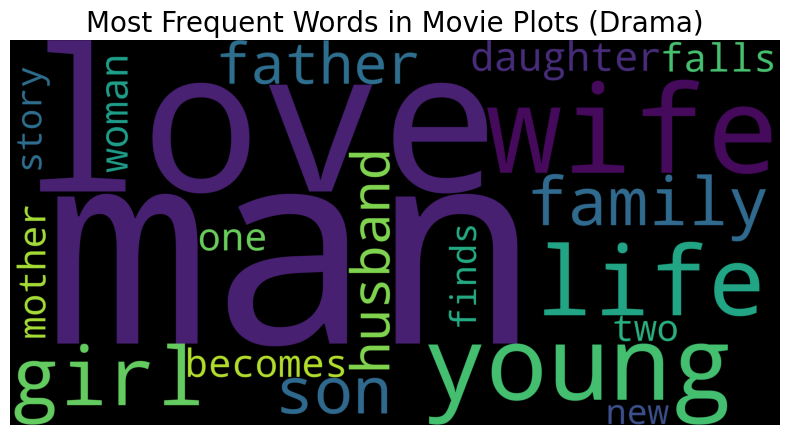

In [752]:
# Uncomment the following line to install wordcloud
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS
# wordcloud
wc_drama = WordCloud(stopwords=STOPWORDS, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(drama_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(wc_drama)
plt.axis('off')
plt.title('Most Frequent Words in Movie Plots (Drama)', fontsize = 20)
plt.show()
# fig.savefig('./img/WordCloudDrama.png');

# We can see patterns of frequent words in the description of movies of type drama
# Notice the existence of "falls" "becomes" "finds": requires NLP preprocessing

In [753]:
# New dataframe with even-sized data in 7 genres
data = pd.concat([df_dra, df_com, df_hor, df_thr, df_act, df_rom])
data

,genre,description
0,Drama,Two men of high rank are both wooing the beaut...
1,Drama,Richard of Gloucester uses manipulation and mu...
2,Drama,After Dr. Friedrich's wife becomes mentally un...
3,Drama,Single mother is separated from her children d...
4,Drama,"Leslie Swayne, an adventurer, in order to obta..."
...,...,...
395,Romance,"Sato is 27 years old, lives in the northern pr..."
396,Romance,"A family entertainer, the story of Ammammagari..."
397,Romance,"Tej, a youngster who's highly attached to his ..."
398,Romance,The film is a rom-com which explores the life ...


In [754]:
data.to_csv("preprocessed_ori_data.csv", index=False)

In [755]:
data = pd.read_csv("preprocessed_ori_data.csv")
data.head()

,genre,description
0,Drama,Two men of high rank are both wooing the beaut...
1,Drama,Richard of Gloucester uses manipulation and mu...
2,Drama,After Dr. Friedrich's wife becomes mentally un...
3,Drama,Single mother is separated from her children d...
4,Drama,"Leslie Swayne, an adventurer, in order to obta..."


In [756]:
df_list = [df_dra, df_com, df_hor, df_thr, df_act, df_rom]

In [757]:
from sklearn.feature_extraction.text import CountVectorizer
def ten_freq(df):
    vec = CountVectorizer(stop_words = 'english')
    
    counts = vec.fit_transform(df['description'])
    count_df = pd.DataFrame(counts.toarray(), columns = vec.get_feature_names_out())
    df_full = pd.concat((df, count_df), axis = 1)
    
    count_list = [df_full[col].sum() for col in df_full.columns[2:]]
    count_list = [ele for ele in count_list if ele.dtype == int]
    
    largest_five_indices = sorted(range(len(count_list)), key=lambda i: count_list[i], reverse=True)[:20]
    largest_five_indices = [i+2 for i in largest_five_indices]
    five_words = [list(df_full.columns)[idx] for idx in largest_five_indices]

    return five_words
    
    # # Select only the filtered columns from the DataFrame
    # df_review = df_review[filtered_cols]
    # df_review.head()

all_lists = [ten_freq(df) for df in df_list]

In [758]:
unique_words = []

for i, current_list in enumerate(all_lists):
    # Flatten all other lists except the current one
    other_words = [word for j, lst in enumerate(all_lists) if j != i for word in lst]
    
    # Filter words that are not in other lists
    unique_to_current_list = [word for word in current_list if word not in other_words]
    
    unique_words.append(unique_to_current_list)

# Display the unique words for each list
for idx, unique in enumerate(unique_words):
    print(f"Unique words in list {idx + 1}: {unique}")

Unique words in list 1: ['mother', 'story', 'war']
Unique words in list 2: ['rich', 'married', 'dagwood', 'job', 'order', 'wealthy']
Unique words in list 3: ['house', 'castle', 'evil', 'doctor', 'vampire', 'women', 'mysterious', 'strange', 'turns', 'village']
Unique words in list 4: ['murder', 'killer', 'serial', 'police', 'men', 'couple', 'years']
Unique words in list 5: ['malone', 'yoshiki', 'gang', 'marshes', 'drug', 'grogan', 'teaches', 'arts', 'agent', 'cop', 'kill', 'brother', 'lead', 'poisoned', 'reunited', 'fight', 'action', 'helmet']
Unique words in list 6: ['lovable', 'gillian', 'lies', 'york', 'mamtaram', 'stories', 'witnessed', 'day', 'meeting', 'fall', 'netherlands', 'meera', 'friends', 'lived', 'scheduled', 'tilok']


In [759]:
df = df_list[5]
df

,genre,description
0,Romance,The adventures of a female reporter in the 1890s.
1,Romance,A small-town girl goes to New York hoping to b...
2,Romance,Mia May has surrendered herself to a disciple ...
3,Romance,An Irish lass is torn between the poet who sed...
4,Romance,"Princess Mary of Burgundy, traveling in disgui..."
...,...,...
395,Romance,"Sato is 27 years old, lives in the northern pr..."
396,Romance,"A family entertainer, the story of Ammammagari..."
397,Romance,"Tej, a youngster who's highly attached to his ..."
398,Romance,The film is a rom-com which explores the life ...


In [760]:
idx_to_df = {0: df_dra, 1: df_com, 2: df_hor, 3: df_thr, 4: df_act, 5: df_rom}
def get_idx(df):
    for idx, dataframe in idx_to_df.items():
        if dataframe.equals(df):
            return idx

In [761]:
genre_list = ['Drama', 'Comedy', 'Horror', 'Thriller', 'Action', 'Romance']
dict_li = list()
for i in range(5):
    df = df_list[i]
    dict = {}
    idx = get_idx(df)
    dict[genre_list[idx]] = list()
    for text in df['description']:
        for unique_freq_words in unique_words[idx]:
            if unique_freq_words in text:
                dict[genre_list[idx]].append(text)
    dict_li.append(dict)

dff_li = []
for i in range(5):
    col = dict_li[i]
    dff = pd.DataFrame({'description': list(col.values())[0]})
    genre = genre_list[i]
    dff["genre"] = genre
    dff_li.append(dff)

In [762]:
final_df = pd.DataFrame()
for dff in dff_li:
    final_df = pd.concat([dff, final_df])

final_df

,description,genre
0,"Murdock inherits an estate in Africa, on which...",Action
1,A destructive ex-motorcycle gang leader comes ...,Action
2,A destructive ex-motorcycle gang leader comes ...,Action
3,The famous swordsman Hsia Feng gathers five ot...,Action
4,Hanzo Itami is an incorruptible Edo officer wh...,Action
...,...,...
64,Unemployed Kihachi and his two sons struggle t...,Drama
65,A young woman reaches maturity and yearns to k...,Drama
66,The suitor rejects elder sister Kunie but like...,Drama
67,A story of burgeoning labor rights amongst poo...,Drama


In [763]:
# Convert to all lower cases and strip spaces at both sides of each text string
final_df['description'] = [str(i).lower().strip() for i in final_df['description']]
final_df.reset_index(drop = True, inplace = True)

# remove all non-english character (except for space), including punctuations
non_english_char = [chr(i) for i in range(0, 32)] + [chr(i) for i in range(33, 65)] + [chr(i) for i in range(92, 97)] + [chr(i) for i in range(123, 256)]
for i in range(len(final_df)):
    for char in non_english_char:
        final_df["description"][i] = str(final_df["description"][i]).replace(char, '')

#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

# defining the function for lemmatization
def lemmatizer(data):
    wordlist = str(data).split(" ")
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in wordlist]
    lemm_text= [wordnet_lemmatizer.lemmatize(word, pos='v') for word in lemm_text]
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in lemm_text]
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='a') for word in lemm_text]
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='r') for word in lemm_text]
    lemm_text = ' '.join(lemm_text)
    return lemm_text

# lemmatize each movie description
final_df['description']=final_df['description'].apply(lemmatizer)

import nltk
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    text_li = text.split(" ")
    output= [i for i in text_li if i not in stopwords]
    return " ".join(output)

final_df['description']= final_df['description'].apply(remove_stopwords)


In [764]:
final_df.to_csv("freq_preprocessed.csv", index=False)

In [765]:
final_df = pd.read_csv("freq_preprocessed.csv")
final_df

,description,genre
0,murdock inherit estate africa satan harvest he...,Action
1,destructive exmotorcycle gang leader come home...,Action
2,destructive exmotorcycle gang leader come home...,Action
3,famous swordsman hsia feng gather five fighter...,Action
4,hanzo itami incorruptible edo officer learn in...,Action
...,...,...
1033,unemployed kihachi two son struggle make end m...,Drama
1034,young woman reach maturity yearn know father m...,Drama
1035,suitor reject elder sister kunie like kimoko y...,Drama
1036,story burgeon labor right amongst poor fisherm...,Drama


In [766]:
import spacy
nlp = spacy.load("en_core_web_sm")
# a function to extract named entites (e.g. director names, country, etc.)
def extract_entities(text):
    # txt_list = text.split(" ")
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    not_wanted = ['GPE', 'DATE', 'ORG', 'MONEY', 'QUANTITY', 'PERCENT', 'ORDINAL', 'CARDINAL']
    for entity in entities:
        if entity[1] in not_wanted:
            text = text.replace(entity[0], "")
    return text

eg = "Sato is 27 years old man living in a horrible city in Japan"
extract_entities(eg)

'Sato is  man living in a horrible city in '

In [767]:
final_df['filtered_des'] = final_df['description'].apply(extract_entities)
final_df.head()

,description,genre,filtered_des
0,murdock inherit estate africa satan harvest he...,Action,murdock inherit estate africa satan harvest he...
1,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...
2,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...
3,famous swordsman hsia feng gather five fighter...,Action,famous swordsman hsia feng gather fighter ral...
4,hanzo itami incorruptible edo officer learn in...,Action,hanzo itami incorruptible officer learn infam...


In [768]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [769]:
def bert_tokenize(text):
    text = text.strip()
    # Tokenize and encode text using batch_encode_plus
    # The function returns a dictionary containing the token IDs and attention masks
    encoding = tokenizer.batch_encode_plus( [text],# List of input texts
        padding=True,              # Pad to the maximum sequence length
        truncation=True,           # Truncate to the maximum sequence length if necessary
        return_tensors='pt',      # Return PyTorch tensors
        add_special_tokens=True    # Add special tokens CLS and SEP
    )
    
    input_ids = encoding['input_ids']  # Token IDs
    attention_mask = encoding['attention_mask']  # Attention mask
    
    # Generate embeddings using BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        word_embeddings = outputs.last_hidden_state  # This contains the embeddings

    # print(torch.mean(word_embeddings[0], dim=0).shape)
    # Return the shape of word embeddings
    return torch.mean(word_embeddings[0], dim=0)

In [770]:
final_df['embeddings'] = final_df['description'].apply(bert_tokenize)
final_df['ner_embeddings'] = final_df['filtered_des'].apply(bert_tokenize)

In [771]:
final_df

,description,genre,filtered_des,embeddings,ner_embeddings
0,murdock inherit estate africa satan harvest he...,Action,murdock inherit estate africa satan harvest he...,"[tensor(0.6118), tensor(0.1248), tensor(0.5140...","[tensor(0.6118), tensor(0.1248), tensor(0.5140..."
1,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...,"[tensor(-0.0080), tensor(-0.1175), tensor(0.65...","[tensor(-0.0080), tensor(-0.1175), tensor(0.65..."
2,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...,"[tensor(-0.0080), tensor(-0.1175), tensor(0.65...","[tensor(-0.0080), tensor(-0.1175), tensor(0.65..."
3,famous swordsman hsia feng gather five fighter...,Action,famous swordsman hsia feng gather fighter ral...,"[tensor(0.0667), tensor(-0.0114), tensor(0.167...","[tensor(0.1070), tensor(-0.0093), tensor(0.121..."
4,hanzo itami incorruptible edo officer learn in...,Action,hanzo itami incorruptible officer learn infam...,"[tensor(-0.5308), tensor(-0.3264), tensor(0.24...","[tensor(-0.5219), tensor(-0.3593), tensor(0.27..."
...,...,...,...,...,...
1033,unemployed kihachi two son struggle make end m...,Drama,unemployed kihachi son struggle make end meet...,"[tensor(-0.1895), tensor(-0.3005), tensor(0.57...","[tensor(-0.1494), tensor(-0.2933), tensor(0.60..."
1034,young woman reach maturity yearn know father m...,Drama,young woman reach maturity yearn know father m...,"[tensor(-0.3642), tensor(-0.1259), tensor(0.75...","[tensor(-0.3642), tensor(-0.1259), tensor(0.75..."
1035,suitor reject elder sister kunie like kimoko y...,Drama,suitor reject elder sister kunie like kimoko y...,"[tensor(-0.2489), tensor(-0.3747), tensor(0.47...","[tensor(-0.2489), tensor(-0.3747), tensor(0.47..."
1036,story burgeon labor right amongst poor fisherm...,Drama,story burgeon labor right amongst poor fisherm...,"[tensor(0.1736), tensor(-0.3615), tensor(0.122...","[tensor(0.2242), tensor(-0.3731), tensor(0.128..."


In [772]:
final_df['genre_no'] = torch.tensor(final_df['genre'].map(genre_encodings))

In [773]:
# final_df.to_csv('features_w_targets_updated(w NER).csv', index=False) 

In [774]:
# final_df = pd.read_csv('features_w_targets_updated(w NER).csv')

In [775]:
final_df

,description,genre,filtered_des,embeddings,ner_embeddings,genre_no
0,murdock inherit estate africa satan harvest he...,Action,murdock inherit estate africa satan harvest he...,"[tensor(0.6118), tensor(0.1248), tensor(0.5140...","[tensor(0.6118), tensor(0.1248), tensor(0.5140...",4
1,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...,"[tensor(-0.0080), tensor(-0.1175), tensor(0.65...","[tensor(-0.0080), tensor(-0.1175), tensor(0.65...",4
2,destructive exmotorcycle gang leader come home...,Action,destructive exmotorcycle gang leader come home...,"[tensor(-0.0080), tensor(-0.1175), tensor(0.65...","[tensor(-0.0080), tensor(-0.1175), tensor(0.65...",4
3,famous swordsman hsia feng gather five fighter...,Action,famous swordsman hsia feng gather fighter ral...,"[tensor(0.0667), tensor(-0.0114), tensor(0.167...","[tensor(0.1070), tensor(-0.0093), tensor(0.121...",4
4,hanzo itami incorruptible edo officer learn in...,Action,hanzo itami incorruptible officer learn infam...,"[tensor(-0.5308), tensor(-0.3264), tensor(0.24...","[tensor(-0.5219), tensor(-0.3593), tensor(0.27...",4
...,...,...,...,...,...,...
1033,unemployed kihachi two son struggle make end m...,Drama,unemployed kihachi son struggle make end meet...,"[tensor(-0.1895), tensor(-0.3005), tensor(0.57...","[tensor(-0.1494), tensor(-0.2933), tensor(0.60...",0
1034,young woman reach maturity yearn know father m...,Drama,young woman reach maturity yearn know father m...,"[tensor(-0.3642), tensor(-0.1259), tensor(0.75...","[tensor(-0.3642), tensor(-0.1259), tensor(0.75...",0
1035,suitor reject elder sister kunie like kimoko y...,Drama,suitor reject elder sister kunie like kimoko y...,"[tensor(-0.2489), tensor(-0.3747), tensor(0.47...","[tensor(-0.2489), tensor(-0.3747), tensor(0.47...",0
1036,story burgeon labor right amongst poor fisherm...,Drama,story burgeon labor right amongst poor fisherm...,"[tensor(0.1736), tensor(-0.3615), tensor(0.122...","[tensor(0.2242), tensor(-0.3731), tensor(0.128...",0


In [776]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=40)

In [777]:
train_df["embeddings"]

20      [tensor(0.1600), tensor(-0.4119), tensor(0.313...
726     [tensor(0.1024), tensor(-0.0135), tensor(0.532...
197     [tensor(-0.0942), tensor(-0.1393), tensor(0.50...
614     [tensor(0.0106), tensor(-0.0468), tensor(0.634...
773     [tensor(-0.1911), tensor(-0.2195), tensor(0.98...
                              ...                        
626     [tensor(0.0025), tensor(-0.1957), tensor(0.315...
1016    [tensor(-0.3426), tensor(0.3188), tensor(0.420...
165     [tensor(-0.0889), tensor(-0.3872), tensor(0.25...
7       [tensor(-0.1570), tensor(-0.1106), tensor(0.32...
219     [tensor(-0.3309), tensor(-0.3691), tensor(0.54...
Name: embeddings, Length: 830, dtype: object

In [778]:
train_df

,description,genre,filtered_des,embeddings,ner_embeddings,genre_no
20,band counterfeiter want make hong kong new ter...,Action,band counterfeiter want make new territory di...,"[tensor(0.1600), tensor(-0.4119), tensor(0.313...","[tensor(0.1989), tensor(-0.3416), tensor(0.194...",4
726,nocturnal car accident english countryside unf...,Horror,nocturnal car accident english countryside unf...,"[tensor(0.1024), tensor(-0.0135), tensor(0.532...","[tensor(0.1024), tensor(-0.0135), tensor(0.532...",2
197,man ling steal two million dollar gangster bos...,Action,man ling steal gangster bos big brother lui w...,"[tensor(-0.0942), tensor(-0.1393), tensor(0.50...","[tensor(-0.0163), tensor(-0.1087), tensor(0.54...",4
614,old man sell soul devil turn young man u witch...,Horror,old man sell soul devil turn young man u witch...,"[tensor(0.0106), tensor(-0.0468), tensor(0.634...","[tensor(0.0106), tensor(-0.0468), tensor(0.634...",2
773,count dracula pregnant granddaughter arrive ca...,Horror,count dracula pregnant granddaughter arrive ca...,"[tensor(-0.1911), tensor(-0.2195), tensor(0.98...","[tensor(-0.1911), tensor(-0.2195), tensor(0.98...",2
...,...,...,...,...,...,...
626,england doctor order cure wife sick mind inje...,Horror,england doctor order cure wife sick mind inje...,"[tensor(0.0025), tensor(-0.1957), tensor(0.315...","[tensor(0.0025), tensor(-0.1957), tensor(0.315...",2
1016,redhaired boy mother punch bag father presenc...,Drama,redhaired boy mother punch bag father presenc...,"[tensor(-0.3426), tensor(0.3188), tensor(0.420...","[tensor(-0.3426), tensor(0.3188), tensor(0.420...",0
165,interpol agent travel india find terrorist kil...,Action,interpol agent travel find terrorist kill par...,"[tensor(-0.0889), tensor(-0.3872), tensor(0.25...","[tensor(-0.0592), tensor(-0.4468), tensor(0.31...",4
7,young karate expert search brother killer hong...,Action,young karate expert search brother killer,"[tensor(-0.1570), tensor(-0.1106), tensor(0.32...","[tensor(-0.1513), tensor(-0.1777), tensor(0.21...",4


In [779]:
# for i in train_df.index:
#     if type(train_df['embeddings'][i]) == str:
#         train_df.drop(index=i, inplace=True)

In [780]:
train1_embeddings = train_df["embeddings"]
train1_labels = train_df["genre_no"]
test1_embeddings = test_df["embeddings"]
test1_labels = test_df["genre_no"]

In [781]:
stacked_train1_embeddings = torch.stack(list(train1_embeddings))
stacked_test1_embeddings = torch.stack(list(test1_embeddings))
stacked_train1_labels = torch.tensor(list(train1_labels))
stacked_test1_labels = torch.tensor(list(test1_labels))

In [782]:
stacked_train1_embeddings[0].size()

torch.Size([768])

In [783]:
# NN stuff
import torch.nn as nn
import torch.optim as optim

# Define the fully connected neural network
class GenreClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(GenreClassifier, self).__init__()
        self.fc1 = nn.Linear(768, hidden_size) 
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size // 4)
        self.fc4 = nn.Linear(hidden_size // 4, hidden_size // 8)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size // 8)
        # Output layer for classification
        self.output = nn.Linear(hidden_size // 8, output_size)
        
        # Activation functions, dropout, and softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output(x)
        
        return self.softmax(x)

# Set parameters
input_size = 768  # For BERT-base embeddings
hidden_size = 512
output_size = 5
dropout_rate = 0.1

# Initialize the model
model1 = GenreClassifier(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)


In [784]:
stacked_train1_labels.size()

torch.Size([830])

In [785]:
# Train the model
# Hyperparameters
num_epochs = 500
batch_size = 2

# Training loop
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model1(stacked_train1_embeddings)
    loss = criterion(outputs, stacked_train1_labels)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/500], Loss: 0.9121
Epoch [200/500], Loss: 0.9120
Epoch [300/500], Loss: 0.9085
Epoch [400/500], Loss: 0.9085
Epoch [500/500], Loss: 0.9085


In [786]:
# Evaluate the model

model.eval()
with torch.no_grad():
    test_outputs = model1(stacked_test1_embeddings)
    predicted = torch.argmax(test_outputs, 1)
    true_labels = stacked_test1_labels
    accuracy = (predicted == true_labels).sum().item() / len(stacked_test1_labels)
    print(f'Accuracy on test data: {accuracy * 100:.2f}%')


Accuracy on test data: 84.13%


In [787]:
# Filter Out the Neutual Name Entity Recognized

In [788]:
train2_embeddings = train_df["ner_embeddings"]
train2_labels = train_df["genre_no"]
test2_embeddings = test_df["ner_embeddings"]
test2_labels = test_df["genre_no"]
stacked_train2_embeddings = torch.stack(list(train2_embeddings))
stacked_test2_embeddings = torch.stack(list(test2_embeddings))
stacked_train2_labels = torch.tensor(list(train2_labels))
stacked_test2_labels = torch.tensor(list(test2_labels))

In [789]:
# NN stuff
import torch.nn as nn
import torch.optim as optim

# Define the fully connected neural network
class GenreClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(GenreClassifier, self).__init__()
        self.fc1 = nn.Linear(768, hidden_size) 
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size // 4)
        self.fc4 = nn.Linear(hidden_size // 4, hidden_size // 8)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size // 8)
        # Output layer for classification
        self.output = nn.Linear(hidden_size // 8, output_size)
        
        # Activation functions, dropout, and softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output(x)
        
        return self.softmax(x)

# Set parameters
input_size = 768  # For BERT-base embeddings
hidden_size = 512
output_size = 5
dropout_rate = 0.1

# Initialize the model
model2 = GenreClassifier(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)


In [790]:
# Train the model
# Hyperparameters
num_epochs = 800
batch_size = 2

# Training loop
for epoch in range(num_epochs):
    model2.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model2(stacked_train1_embeddings)
    loss = criterion(outputs, stacked_train1_labels)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/800], Loss: 0.9114
Epoch [200/800], Loss: 0.9085
Epoch [300/800], Loss: 0.9085
Epoch [400/800], Loss: 0.9085
Epoch [500/800], Loss: 0.9085
Epoch [600/800], Loss: 0.9085
Epoch [700/800], Loss: 0.9085
Epoch [800/800], Loss: 0.9085


In [791]:
# Evaluate the model

model.eval()
with torch.no_grad():
    test_outputs = model2(stacked_test2_embeddings)
    predicted = torch.argmax(test_outputs, 1)
    true_labels = stacked_test2_labels
    accuracy = (predicted == true_labels).sum().item() / len(stacked_test2_labels)
    print(f'Accuracy on test data: {accuracy * 100:.2f}%')

Accuracy on test data: 85.58%
